In [1]:
from datetime import date, datetime
from decimal import Decimal
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy import select, and_
from sqlalchemy.orm import Session

import pandas as pd

sns.set_theme()

In [2]:
import typed_settings as ts
from paralysis.settings import ParalysisSettings
from paralysis.model import Round, Feedback

settings = ts.load(ParalysisSettings, appname="paralysis", config_files=["prod.toml"])

In [3]:

engine = create_engine(settings.connection_string)

In [4]:
query = select(Feedback).filter(Feedback.json.contains("Demon Incursion"))

In [5]:
session = Session(engine)
feedbacks = pd.DataFrame(session.execute(query).unique().scalars())

In [6]:
feedbacks[0][0]

<Fdbk Rnd#45171 biohazards>

In [7]:
round_ids = set([f.round_id for f in feedbacks[0]])

In [8]:
round_ids

{45170,
 45171,
 45183,
 45217,
 45235,
 45247,
 45276,
 45278,
 45288,
 45291,
 45309,
 45311,
 45312,
 45317,
 45319,
 45322,
 45327,
 45331,
 45339,
 45354,
 45405,
 45414,
 45428,
 45440,
 45448}

In [9]:
query = select(Round).filter(Round.id.in_(round_ids))
rounds = pd.DataFrame(session.execute(query).unique().scalars())

In [10]:
rounds

,0
0,<Round#45170 [2025-06-21] Dynamic/EmeraldStation>
1,<Round#45171 [2025-06-22] Dynamic/CereStation>
2,<Round#45183 [2025-06-23] Dynamic/BoxStation>
3,<Round#45217 [2025-06-26] Dynamic/DeltaStation>
4,<Round#45235 [2025-06-28] Dynamic/BoxStation>
5,<Round#45247 [2025-06-29] Dynamic/MetaStation>
6,<Round#45276 [2025-07-01] Dynamic/EmeraldStation>
7,<Round#45278 [2025-07-02] Dynamic/MetaStation>
8,<Round#45288 [2025-07-03] Dynamic/MetaStation>
9,<Round#45291 [2025-07-03] Dynamic/DeltaStation>


In [14]:
def get_data(row):
    r = row[0]
    biohazards = r.feedback("biohazards")
    if not biohazards:
        return None
    biohazard_pop_5min_interval = r.feedback("biohazard_pop_5min_interval")
    biohazard_starts = r.feedback("biohazard_starts")
    survived = biohazards.get("survived", {})
    defeated = biohazards.get("defeated", {})
    status = "unknown"
    if "Demon Incursion" in survived:
        status = "survived"
    elif "Demon Incursion" in defeated:
        status = "defeated"
    pop = biohazard_pop_5min_interval["Demon Incursion"]
    start_time = 0
    for start in biohazard_starts.values():
        if start["type"] == "Demon Incursion":
            start_time = start["time_ds"]
    return pd.Series({
        "round_id": r.id,
        "status": status,
        "pop_5min_sampling": pop,
        "start_time_minutes": int(Decimal(start_time) / 10 / 60),
    })

In [15]:
df = rounds.apply(get_data, axis=1)

In [17]:
import matplotlib.pyplot as plt

In [25]:
df = df[df.round_id>0]

In [29]:
df.tail(10)

,round_id,status,pop_5min_sampling,start_time_minutes
14,45319.0,defeated,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",72.0
15,45322.0,defeated,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",66.0
16,45327.0,defeated,"[0, 4, 6, 9, 8, 8, 8, 10, 12, 10, 11, 0]",58.0
17,45331.0,survived,"[0, 10, 10, 17, 15, 16, 18, 21, 20, 14, 4, 4, ...",64.0
18,45339.0,defeated,"[0, 9, 9, 9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",56.0
19,45354.0,survived,"[0, 8, 12, 18]",114.0
20,45405.0,survived,[0],132.0
22,45428.0,survived,"[0, 5, 7, 13, 13, 14, 15, 14, 17, 18, 20]",73.0
23,45440.0,survived,"[0, 8, 10, 12, 13]",108.0
24,45448.0,survived,"[0, 4]",122.0


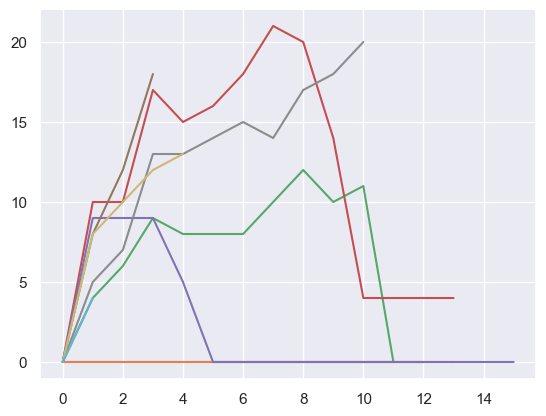

In [31]:
for i, row in df.tail(10).iterrows():
    plt.plot(row['pop_5min_sampling'])